In [1]:
import sys
sys.path.append('/home/jbq/repositories/sans-backend/sans-backend2')
import time
import os
data_dir = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration'

In [7]:
# "plot_workspace" is a utility function, which we will use a couple of times
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

<h3>Barscan calculation</h3>

Using a Nexus Event file for GPSANS (CG2_7465.nxs.h5) containing a full barscan, we calculate effective pixel positions (along the vertical, Y-coordinate) and pixel heights.

Here we show metadata "dcal_Readback", containing the positions of the bar as a function or elapsed time since the start of the run.

<img src="files/bar_position.png" height="600">

**Functions and Algorithms used:**
- [calculate_barscan_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration)

In addition to the calibration, we want other pieces of data that will help up assess the sucess of the calibration. Thus, we pass option `inspect_data=True` to function `calculate_barscan_calibration`.

**Note:** Calculating the calibration takes in between 1 and five minutes. Although it's slow, new calibrations are supposed to happen not more than once or twice per cycle.

In [3]:
from drtsans.pixel_calibration import calculate_barscan_calibration
barscan_file = os.path.join(data_dir, 'CG2_7465.nxs.h5')
start_time = time.time()
calibration, addons = calculate_barscan_calibration(barscan_file, inspect_data=True)  # calibration for array 'detector1'
print('Calibration took ', int((time.time() - start_time) / 60), 'minutes')

Calibration took  4 minutes


In [4]:
print(addons.keys())

dict_keys(['bar_positions', 'bar_workspaces', 'bottom_shadow_pixels'])


The `addons` is a python dictionary containing the list of **bar positions** and list of **bar workspaces**. The list **bar workspaces** contains the intensities for the bar being held at a particular position.

Let's plot the intensities for the bar positionen in the middle of the detector array.

middel scan index = 55


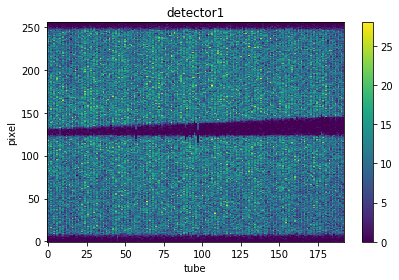

In [10]:
number_of_scans = len(addons['bar_positions'])
middle_scan_index = int(number_of_scans / 2)
print('middel scan index =', middle_scan_index)
middle_workspace = addons['bar_workspaces'][middle_scan_index]
plot_workspace(middle_workspace)

<h3>Plotting the calibration</h3>

We can create a **2D intensity plot** for the pixel positions and heights using the `as_intensities` method of the calibration object (the calibration is a table of type [Table](https://code.ornl.gov/sns-hfir-scse/sans/sans-backend/blob/next/drtsans%2Fpixel_calibration.py#L90))

**Functions and Algorithms used:**
- [plot_detector](http://docs.drt-sans.ornl.gov/drtsans/plots.html#drtsans.plots.plot_detector)

In [ ]:
views = calibration.as_intensities()  # returns two workspaces, one for positions and other for widths

In [ ]:
plot_workspace(views.positions)
plot_workspace(views.heights)

We save the views with Mantid algorithm [SaveNexus](https://docs.mantidproject.org/nightly/algorithms/SaveNexus-v1.html). Later these files can be imported into MantidWorkbench or MantidPlot with [LoadNexus](https://docs.mantidproject.org/nightly/algorithms/LoadNexus-v1.html) and use the [instrument view widget](https://docs.mantidproject.org/nightly/tutorials/mantid_basic_course/connecting_data_to_instruments/01_introduction.html#introduction-conn)

In [ ]:
from mantid.simpleapi import SaveNexus
SaveNexus(views.positions, Filename='/tmp/positions.nxs')
SaveNexus(views.heights, Filename='/tmp/heights.nxs')

<h3>Saving the calibration</h3>

Calibration objects are saved to a database as two separate pieces:  

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. Their locations for their respective metadata JSON files:

- BIOSANS: '/HFIR/CG3/shared/calibration/pixel_calibration.json'
- EQSANS: '/SNS/EQSANS/shared/calibration/pixel_calibration.json'
- GPSANS: '/HFIR/CG2/shared/calibration/pixel_calibration.json'

Data tables are saved under `tables/` subdirectory:

- BIOSANS: '/HFIR/CG3/shared/calibration/tables'
- EQSANS: '/SNS/EQSANS/shared/calibration/tables'
- GPSANS: '/HFIR/CG2/shared/calibration/tables'

In this example, we don't want to pollute the default database so we save the calibration under `/tmp` directory. The statement below will create files `/tmp/calibration/metadata.json` and `/tmp/calibration/tables/barscan_GPSANS_detector1_20200103.nxs`.
We use argument overwrite=True in case we run the notebook more than once. Then we will overwrite the existing 
calibration entry in the database

In [ ]:
calibration.save(database='/tmp/calibration/metadata.json', overwrite=True)

<h3>Loading and applying a calibration</h3>

Here we will load and apply the calibration we just saved onto one of the slices of calibration run `CG2_9159.nxs.h5`.We use function load_calibration and `Table` method `apply`.

We inspect whether the calibration has been applied with function `as_intensities`.

**Functions and Algorithms used:**
- [LoadEventNexus](https://docs.mantidproject.org/nightly/algorithms/LoadEventNexus-v1.html)
- [as_intensities](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.as_intensities)

In [ ]:
# Load the run to which we will apply the calibration
from mantid.simpleapi import LoadNexus
LoadNexus(os.path.join(data_dir, 'scan_88.nxs'), OutputWorkspace='scan_88')

In [ ]:
# Visualize the pixel positions and heights before the calibration is applied
from drtsans.pixel_calibration import as_intensities
uncalibrated_views = as_intensities('scan_44')
plot_workspace(uncalibrated_views.positions)

In [ ]:
plot_workspace(uncalibrated_views.positions)

`as_intensities` creates a view of pixels' vertical positions that always assign a value of `y=0` to the bottom pixels. This is done intentionally so that the vertical positions are not masked in the instrument view of Mantid. The instrument view will mask any negative intensities.

In [ ]:
plot_workspace(uncalibrated_views.heights)

The previous plot has only one color because all uncalibrated pixels have the same height.

Now we load and apply the calibration that we just saved.

**Functions and Algorithms used:**
- [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration)

In [ ]:
# Load the calibration
from drtsans.pixel_calibration import load_calibration
calibration = load_calibration('scan_44', 'BARSCAN',
                               database=os.path.join(data_dir, 'saved_calibrations.json'))

In [ ]:
# Apply the calibration.
start_time = time.time()
calibration.apply('scan_88', output_workspace='scan_88_calibrated')
print(f'Applying the calibration took {time.time() - start_time:.1} seconds')

In [ ]:
# Visualize the pixel positions and heights after the calibration is applied
calibrated_views = as_intensities('scan_44_calibrated')
plot_workspace(calibrated_views.positions)
plot_workspace(calibrated_views.heights)

Notice that the statement `calibration.apply('uncalibrated', output_workspace='calibrated')` has generated a new workspace, `calibrated`. This workspace is a clone of `uncalibrated` except for the pixel positions and heights.

If you want to reuse the input workspace instead of generating a clone, then omit argument `output_workspace`, like this: `calibration.apply('uncalibrated')`. Now workspace `uncalibrated` will have calibrated pixel positions and heights.

In [ ]:
plot_detector('scan_88', axes_mode='xy')

In [ ]:
plot_detector('scan_88_calibrated', axes_mode='xy')